# **Regression Analysis - Model Selection & Diagnostics**

**Aim:** Build a defensible multiple linear regression (MLR) model with rigorous model selection and diagnostics.

**Steps:**
- Data audit, cleansing, and EDA
- Encoding & transformations; multicollinearity checks (VIF)
- **Forward stepwise selection** using **Adjusted $R^2$**, **Mallows' $C_p$**, and **AIC**
- Compute **PRESS** and compare nested models
- Residual diagnostics; **Cook's distance**, **leverage**, **DFFITS**, **DFBETAS**, QQ, Scale–Location
- Remediate influential points and re‑fit; compare pre/post metrics
- Hold‑out test evaluation (RMSE, $R^2$) + clean reporting tables


## 0. Setup
Install/import libraries and set display options.

In [2]:

import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 120)


## 1. Load Data

In [3]:

import pandas as pd
from pathlib import Path
train_path = "/content/train.csv"
test_path = "/content/test.csv"
df = pd.read_csv(train_path)
df.shape, df.head(3)


((1460, 81),
    Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 0   1          60       RL         65.0     8450   Pave   NaN      Reg   
 1   2          20       RL         80.0     9600   Pave   NaN      Reg   
 2   3          60       RL         68.0    11250   Pave   NaN      IR1   
 
   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
 0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
 1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
 2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
 
   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
 0       Norm     1Fam     2Story            7            5       2003   
 1       Norm     1Fam     1Story            6            8       1976   
 2       Norm     1Fam     2Story            7            5       2001   
 
    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
 0          2003     Ga

## 2. Data Audit & Basic Cleaning

In [4]:

audit = pd.DataFrame({
    'dtype': df.dtypes,
    'n_missing': df.isna().sum(),
    'n_unique': df.nunique()
}).sort_values(['n_missing','n_unique'], ascending=[False, True])
audit.head(20)


,dtype,n_missing,n_unique
PoolQC,object,1453,3
MiscFeature,object,1406,4
Alley,object,1369,2
Fence,object,1179,4
MasVnrType,object,872,3
FireplaceQu,object,690,5
LotFrontage,float64,259,110
GarageFinish,object,81,3
GarageQual,object,81,5
GarageCond,object,81,5


In [5]:

cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(include=['int64','float64']).columns.drop('SalePrice').tolist()
len(cat_cols), len(num_cols), cat_cols[:10], num_cols[:10]


(43,
 37,
 ['MSZoning',
  'Street',
  'Alley',
  'LotShape',
  'LandContour',
  'Utilities',
  'LotConfig',
  'LandSlope',
  'Neighborhood',
  'Condition1'],
 ['Id',
  'MSSubClass',
  'LotFrontage',
  'LotArea',
  'OverallQual',
  'OverallCond',
  'YearBuilt',
  'YearRemodAdd',
  'MasVnrArea',
  'BsmtFinSF1'])

In [6]:

from sklearn.impute import SimpleImputer
df_clean = df.copy()
num_imputer = SimpleImputer(strategy='median')
df_clean[num_cols] = num_imputer.fit_transform(df_clean[num_cols])
cat_imputer = SimpleImputer(strategy='most_frequent')
df_clean[cat_cols] = cat_imputer.fit_transform(df_clean[cat_cols])
df_clean.isna().sum().sum()


np.int64(0)

## 3. Feature Engineering & Encoding

In [7]:

X_full = pd.get_dummies(df_clean.drop(columns=['SalePrice']), drop_first=True)
y_full = np.log1p(df_clean['SalePrice'])
X_full.shape, y_full.shape


((1460, 245), (1460,))

## 4. Train/Validation Split

In [8]:

from sklearn.model_selection import train_test_split
y_bins = pd.qcut(y_full, q=10, duplicates='drop')
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_bins
)
X_train.shape, X_val.shape


((1168, 245), (292, 245))

## 5. Multicollinearity Screening (VIF)

In [15]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(X, max_features=30):
    if X.shape[1] > max_features:
        cols = X.var().sort_values(ascending=False).head(max_features).index
        X = X[cols].copy()
    X_ = sm.add_constant(X)
    vif = pd.DataFrame({
        'feature': X_.columns,
        'VIF': [variance_inflation_factor(X_.values, i) for i in range(X_.shape[1])]
    })
    return vif[vif['feature']!='const'].sort_values('VIF', ascending=False)

# Use correlation with y to choose a manageable subset for VIF
corrs = X_train.apply(lambda col: np.corrcoef(col, y_train)[0,1])
# Drop the 'Id' column before calculating VIF as it is not a predictor
X_train_no_id = X_train.drop(columns=['Id'])
corrs_no_id = X_train_no_id.apply(lambda col: np.corrcoef(col, y_train)[0,1])

# Select only numeric columns before calculating VIF
numeric_cols = X_train_no_id.select_dtypes(include=np.number).columns.tolist()
X_train_numeric = X_train_no_id[numeric_cols]

# Filter the correlated columns to only include those in the numeric DataFrame
correlated_numeric_cols = corrs_no_id.abs().sort_values(ascending=False).head(30).index.intersection(X_train_numeric.columns)

vif_table = compute_vif(X_train_numeric[correlated_numeric_cols], max_features=30)
vif_table.head(10)

,feature,VIF
3,GarageCars,5.512024
2,GrLivArea,5.424573
4,GarageArea,5.218979
5,TotalBsmtSF,3.795574
6,1stFlrSF,3.688507
8,YearBuilt,3.498495
10,TotRmsAbvGrd,3.450995
11,GarageYrBlt,2.998951
1,OverallQual,2.968552
7,FullBath,2.277037


## 6. Baseline OLS

In [17]:
topk = corrs.abs().sort_values(ascending=False).head(25).index.tolist()

# Filter topk to include only numeric columns from X_train
numeric_cols_in_topk = [col for col in topk if col in X_train.select_dtypes(include=np.number).columns]

Xb = sm.add_constant(X_train[numeric_cols_in_topk])
ols_baseline = sm.OLS(y_train, Xb).fit()
print(ols_baseline.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     369.5
Date:                Wed, 13 Aug 2025   Prob (F-statistic):               0.00
Time:                        14:24:16   Log-Likelihood:                 450.20
No. Observations:                1168   AIC:                            -868.4
Df Residuals:                    1152   BIC:                            -787.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.2707      0.685      4.771   

## 7. Forward Stepwise Selection (AdjR2 / Cp / AIC)

In [19]:
from typing import List
def fit_ols(X, y, cols):
    X_ = sm.add_constant(X[cols])
    return sm.OLS(y, X_).fit()

def mallows_cp(sse_k, sigma2_hat, n, p):
    return sse_k / sigma2_hat - (n - 2*p)

# 'Full' variance estimate using top 100 features
full_cols = corrs.abs().sort_values(ascending=False).head(min(100, X_train.shape[1])).index.tolist()

# Filter full_cols to include only numeric columns from X_train
numeric_full_cols = [col for col in full_cols if col in X_train.select_dtypes(include=np.number).columns]

full_model = fit_ols(X_train, y_train, numeric_full_cols)
sigma2_hat = full_model.mse_resid
n_train = X_train.shape[0]

def forward_stepwise(X, y, candidate_cols: List[str], criterion: str='adjr2', max_steps: int=30):
    selected, history = [], []
    for step in range(max_steps):
        best_score, best_col, best_model = None, None, None
        remaining = [c for c in candidate_cols if c not in selected]
        if not remaining:
            break
        for c in remaining:
            cols_try = selected + [c]
            m = fit_ols(X, y, cols_try)
            if criterion == 'adjr2':
                score, better = m.rsquared_adj, (best_score is None or m.rsquared_adj > best_score)
            elif criterion == 'aic':
                score, better = -m.aic, (best_score is None or -m.aic > best_score)
            elif criterion == 'cp':
                p = len(cols_try) + 1
                cp = mallows_cp(m.ssr, sigma2_hat, n_train, p)
                score, better = -cp, (best_score is None or -cp > best_score)
            else:
                raise ValueError('criterion must be adjr2/aic/cp')
            if better:
                best_score, best_col, best_model = score, c, m
        if best_col is None: break
        selected.append(best_col)
        history.append((step+1, best_col, best_score, best_model.rsquared, best_model.rsquared_adj, best_model.aic))
    return selected, history

# Filter candidates to include only numeric columns from X_train
numeric_candidates = X_train.select_dtypes(include=np.number).columns.tolist()

sel_adjr2, hist_adjr2 = forward_stepwise(X_train, y_train, numeric_candidates, 'adjr2', 30)
sel_cp,    hist_cp    = forward_stepwise(X_train, y_train, numeric_candidates, 'cp',    30)
sel_aic,   hist_aic   = forward_stepwise(X_train, y_train, numeric_candidates, 'aic',   30)

def hist_to_df(hist, label):
    return pd.DataFrame(hist, columns=['step','feature','score','R2','Adj_R2','AIC']).assign(criterion=label)
hist_df = pd.concat([hist_to_df(hist_adjr2,'adjr2'), hist_to_df(hist_cp,'cp'), hist_to_df(hist_aic,'aic')])
hist_df.groupby('criterion').head(10)

,step,feature,score,R2,Adj_R2,AIC,criterion
0,1,OverallQual,0.662094,0.662384,0.662094,-109.349331,adjr2
1,2,GrLivArea,0.727762,0.728228,0.727762,-360.743008,adjr2
2,3,YearBuilt,0.770791,0.771380,0.770791,-560.690546,adjr2
3,4,OverallCond,0.792565,0.793276,0.792565,-676.279965,adjr2
4,5,GarageCars,0.810088,0.810902,0.810088,-778.371958,adjr2
5,6,BsmtFullBath,0.826188,0.827082,0.826188,-880.847939,adjr2
6,7,MSSubClass,0.836702,0.837681,0.836702,-952.730611,adjr2
7,8,Fireplaces,0.843237,0.844312,0.843237,-999.442486,adjr2
8,9,ScreenPorch,0.845332,0.846525,0.845332,-1014.168710,adjr2
9,10,WoodDeckSF,0.847762,0.849067,0.847762,-1031.672991,adjr2


## 8. PRESS Comparison

In [20]:

from statsmodels.stats.outliers_influence import OLSInfluence

def compute_press(model):
    infl = OLSInfluence(model)
    resid = model.resid.values
    hii = infl.hat_matrix_diag
    return np.sum((resid / (1 - hii))**2)

def model_from_selection(sel, max_p=15):
    cols = sel[:max_p]
    m = fit_ols(X_train, y_train, cols)
    return cols, m

cand = {}
for label, sel in [('AdjR2', sel_adjr2), ('Cp', sel_cp), ('AIC', sel_aic)]:
    cols, m = model_from_selection(sel, max_p=15)
    cand[label] = {'cols': cols, 'model': m, 'press': compute_press(m)}

pd.DataFrame({k: {'p': len(v['cols']), 'Adj_R2': v['model'].rsquared_adj, 'AIC': v['model'].aic, 'PRESS': v['press']}
              for k,v in cand.items()}).T.sort_values('PRESS')


,p,Adj_R2,AIC,PRESS
AdjR2,15.0,0.854168,-1076.944402,30.216218
Cp,15.0,0.854168,-1076.944402,30.216218
AIC,15.0,0.854168,-1076.944402,30.216218


## 9. Diagnostics & Influence

In [21]:

best_key = min(cand, key=lambda k: cand[k]['press'])
best = cand[best_key]
best_model = best['model']
from statsmodels.stats.outliers_influence import OLSInfluence
infl = OLSInfluence(best_model)

p = len(best['cols']) + 1
n = X_train.shape[0]
cook_thr = 4 / (n - p)
lev_thr = 2 * p / n
dffits_thr = 2 * np.sqrt(p / n)

diag_tbl = pd.DataFrame({
    'resid': best_model.resid,
    'std_resid': infl.resid_studentized_internal,
    'hat': infl.hat_matrix_diag,
    'cooks_d': infl.cooks_distance[0],
    'dffits': infl.dffits[0],
})
diag_tbl.assign(
    leverage_flag=lambda d: d['hat'] > lev_thr,
    cooks_flag=lambda d: d['cooks_d'] > cook_thr,
    dffits_flag=lambda d: d['dffits'].abs() > dffits_thr
).describe().T


,count,mean,std,min,25%,50%,75%,max
resid,1168.0,7.949547e-13,0.150585,-1.814557e+00,-0.071840,0.005327,0.080681,0.502771
std_resid,1168.0,-7.940389e-04,1.024130,-1.389059e+01,-0.476382,0.035468,0.534562,3.850975
hat,1168.0,1.369863e-02,0.022110,3.047274e-03,0.007469,0.009762,0.014471,0.518861
cooks_d,1168.0,4.891278e-03,0.122830,8.456969e-11,0.000034,0.000148,0.000556,4.173803
dffits,1168.0,-3.991913e-03,0.300359,-8.952465e+00,-0.047752,0.003583,0.048916,2.284405


### Diagnostic Plots

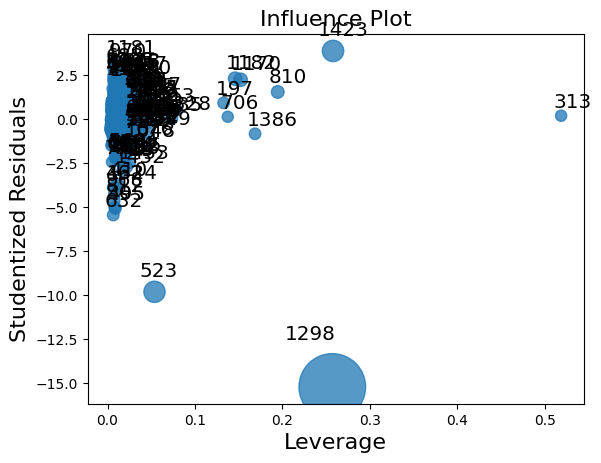

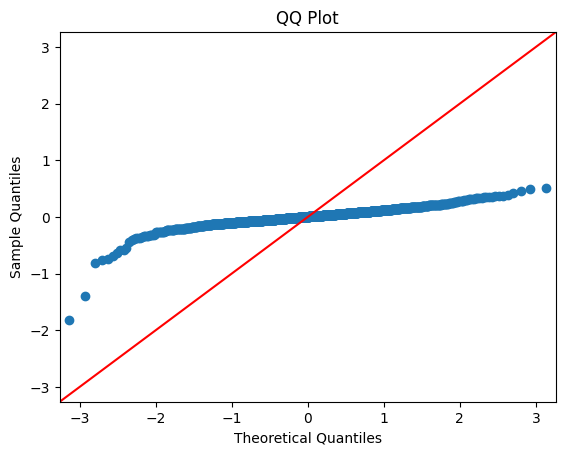

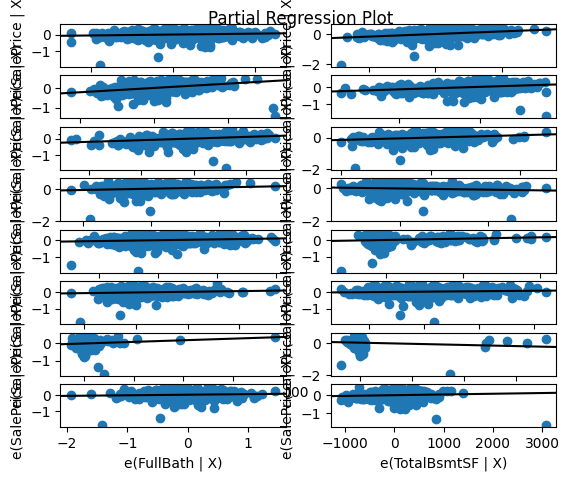

In [22]:

import statsmodels.api as sm
fig = sm.graphics.influence_plot(best_model, criterion="cooks")
plt.show()

sm.qqplot(best_model.resid, line='45'); plt.title('QQ Plot'); plt.show()

from statsmodels.graphics.regressionplots import plot_partregress_grid
fig = plot_partregress_grid(best_model); fig.tight_layout(); plt.show()


## 10. Remediation & Refit

In [23]:

p = len(best['cols']) + 1
n = X_train.shape[0]
cook_thr = 4 / (n - p)
lev_thr = 2 * p / n
dffits_thr = 2 * np.sqrt(p / n)

flags = ((diag_tbl['hat'] > lev_thr) | (diag_tbl['cooks_d'] > cook_thr) | (diag_tbl['dffits'].abs() > dffits_thr))
influential_idx = diag_tbl.index[flags]

Xtr_ref = X_train.drop(index=influential_idx)
ytr_ref = y_train.drop(index=influential_idx)

import statsmodels.api as sm
def fit_ols_cols(X, y, cols):
    return sm.OLS(y, sm.add_constant(X[cols])).fit()

refit = fit_ols_cols(Xtr_ref, ytr_ref, best['cols'])

def compute_press(model):
    from statsmodels.stats.outliers_influence import OLSInfluence
    infl = OLSInfluence(model)
    resid = model.resid.values
    hii = infl.hat_matrix_diag
    return np.sum((resid / (1 - hii))**2)

press_before = compute_press(best_model)
press_after = compute_press(refit)

pd.DataFrame({
    'metric': ['n_obs','Adj_R2','AIC','PRESS'],
    'Before': [n, best_model.rsquared_adj, best_model.aic, press_before],
    'After': [Xtr_ref.shape[0], refit.rsquared_adj, refit.aic, press_after]
})


,metric,Before,After
0,n_obs,1168.000000,1072.000000
1,Adj_R2,0.854168,0.919703
2,AIC,-1076.944402,-1804.213929
3,PRESS,30.216218,11.707667


## 11. Hold-Out Validation

In [24]:

from sklearn.metrics import mean_squared_error, r2_score
def eval_on_val(model, cols):
    Xv = sm.add_constant(X_val[cols])
    yv_pred = model.predict(Xv)
    rmse = np.sqrt(mean_squared_error(y_val, yv_pred))
    r2 = r2_score(y_val, yv_pred)
    return rmse, r2

rmse_before, r2_before = eval_on_val(best_model, best['cols'])
rmse_after, r2_after = eval_on_val(refit, best['cols'])
pd.DataFrame({'RMSE':[rmse_before, rmse_after], 'R2':[r2_before, r2_after]},
             index=['Before (raw train)','After (influence removed)'])


,RMSE,R2
Before (raw train),0.132902,0.894676
After (influence removed),0.141296,0.880952


In [12]:
non_finite_cols = X_train_no_id.columns[~np.isfinite(X_train_no_id).all()]
print("Columns with non-finite values:", non_finite_cols)

Columns with non-finite values: Index([], dtype='object')
